# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [248]:
%%pycodestyle
from scipy.spatial.distance import cdist


class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', tol=0.0001):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.tol = tol
        self.init = init

    def _split_x(self, X):
        return X, np.ones((X.shape[0]), dtype=bool)

    def _kpp_init_centroids(self, X):
        self.centroids = np.zeros((self.k, X.shape[1]))
        self.centroids[0] = X[int(np.random.rand()*X.shape[0])]
        for i in range(1, self.k):
            dx_all = np.empty((X.shape[0], i))
            for j in range(i):
                dx_all[:, j] = ((X - self.centroids[j])**2).sum(axis=1)
            dx = np.min(dx_all, axis=1)
            sum_dx = dx.sum()
            rnd = np.random.rand()*sum_dx
            sorted_dx_indexes = np.argsort(dx)
            sorted_dx = dx[sorted_dx_indexes]
            dx_cumsum = np.cumsum(sorted_dx)
            distance = (dx_cumsum[rnd > dx_cumsum])[-1]
            self.centroids[i] = X[(sorted_dx_indexes[rnd > dx_cumsum])[-1]]

    def _rand_init_centroids(self, X):
        indexes = (np.random.sample(self.k)*X.shape[0]).astype(int)
        self.centroids = X[indexes]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        self.iters = 0

        X_splited, splited_indexes = self._split_x(X)
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=int)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here

        # init centroids
        if(self.init == 'random'):
            self._rand_init_centroids(X)
        elif(self.init == 'k-means'):
            self._kpp_init_centroids(X)

        # calculate labels
        distance_matrix = cdist(X, self.centroids, self.metric)
        self.labels = distance_matrix.argmin(axis=1)
        last_centroids = self.centroids+1000
        splited_labels = self.labels[splited_indexes]
        for _ in range(self.max_iter):
            self.iters += 1
            X_and_labels_sorted = np.column_stack(
                (X_splited, splited_labels.T)
            )[np.argsort(splited_labels)]

            delimiter_indexes = np.where(
                X_and_labels_sorted[1:, -1] != X_and_labels_sorted[:-1, -1]
            )[0]

            delimiter_indexes = np.append(delimiter_indexes,
                                          X_and_labels_sorted.shape[0])

            last_index = 0
            k = delimiter_indexes.shape[0]
            for i in range(k):
                self.centroids[i] = np.mean(
                    X_and_labels_sorted[
                        last_index: delimiter_indexes[i], :-1
                    ],
                    axis=0
                )
                last_index = delimiter_indexes[i]

            X_splited, splited_indexes = self._split_x(X)
            distance_matrix = cdist(X_splited, self.centroids, self.metric)

            self.labels[splited_indexes] = distance_matrix.argmin(axis=1)
            splited_labels = self.labels[splited_indexes]

            if(np.sum((last_centroids - self.centroids)**2) < self.tol):
                break

            last_centroids = self.centroids.copy()

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        distance_matrix = cdist(X, self.centroids, self.metric)
        return distance_matrix.argmin(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', tol=0.001,
                 delimiter_pecent=0.1):

        super().__init__(k, metric, max_iter, random_state, init, tol)
        self.delimiter_pecent = delimiter_pecent

    def _split_x(self, X):
        indexes = np.random.sample(X.shape[0]) < self.delimiter_pecent
        return X[indexes], indexes


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [5]:
from sklearn.datasets import make_blobs

In [104]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

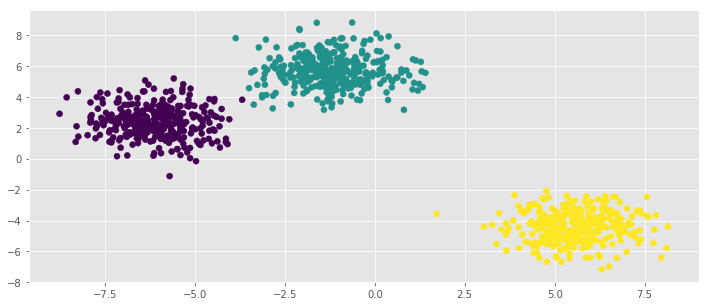

In [62]:
plt.scatter(X[:,0], X[:, 1], c=y)


In [114]:
def time_test_plot(kmeans):
    times = np.zeros(10)
    
    samples = np.linspace(1000, 10000000, 10).astype(int)
    for _ in range(3):  
        for i in range(10):
            X, y = make_blobs(n_samples=samples[i], n_features=2, centers=3, cluster_std=1, 
                   center_box=(-10.0, 10.0), shuffle=False)
            start_time = time.time()
            kmeans.fit(X)
            times[i] += time.time() - start_time

    times = times / 3.

    plt.plot(samples, times)
    plt.xlabel("samples")
    plt.ylabel("average_time")


Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

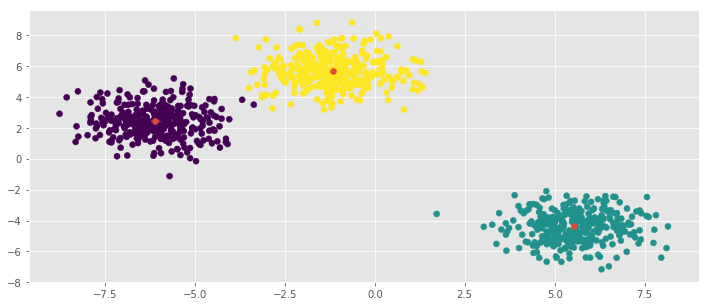

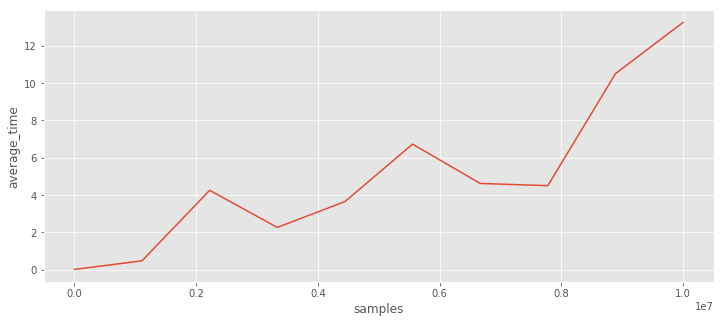

In [116]:
## Работоспособность MyKmeans
cm = MyKmeans(k=3, init='random')
cm.fit(X)
plt.scatter(X[:,0], X[:, 1], c=cm.labels)
plt.scatter(cm.centroids[:,0],cm.centroids[:,1])
plt.show()

time_test_plot(cm)

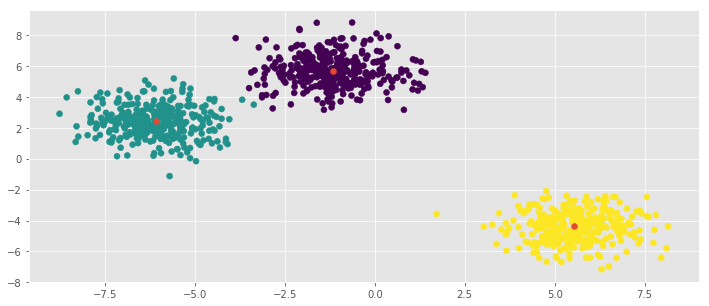

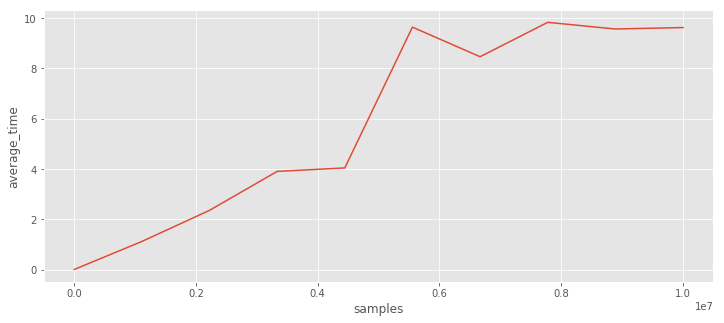

In [111]:
## Работоспособность MyKmeans++
cm = MyKmeans(k=3, init='k-means')
cm.fit(X)
plt.scatter(X[:,0], X[:, 1], c=cm.labels)
plt.scatter(cm.centroids[:,0],cm.centroids[:,1])
plt.show()

time_test_plot(cm)

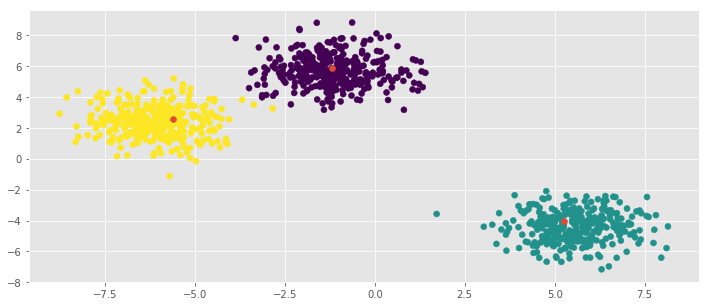

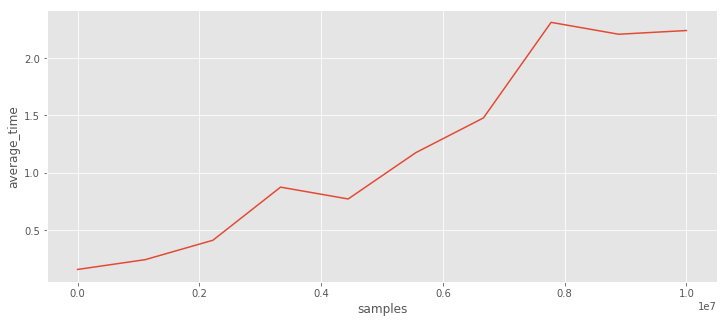

In [108]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
cm = MiniBatchKMeans(k=3)
cm.fit(X)
plt.scatter(X[:,0], X[:, 1], c=cm.predict(X))
plt.scatter(cm.centroids[:,0],cm.centroids[:,1])
plt.show()

time_test_plot(cm)

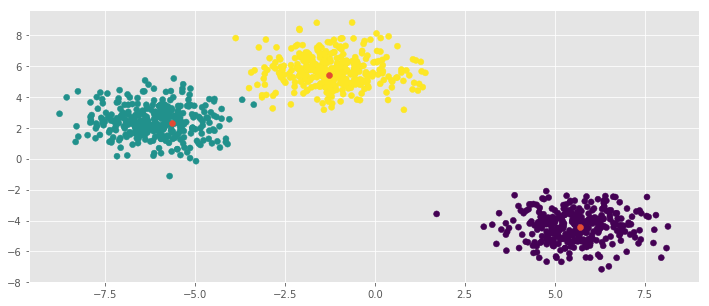

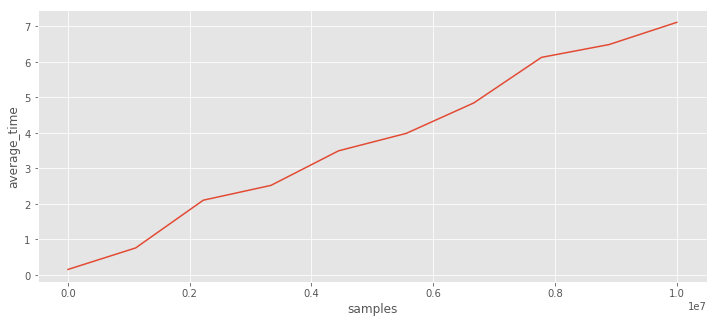

In [109]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
cm = MiniBatchKMeans(k=3, init='k-means')
cm.fit(X)
plt.scatter(X[:,0], X[:, 1], c=cm.predict(X))
plt.scatter(cm.centroids[:,0],cm.centroids[:,1])
plt.show()

time_test_plot(cm)

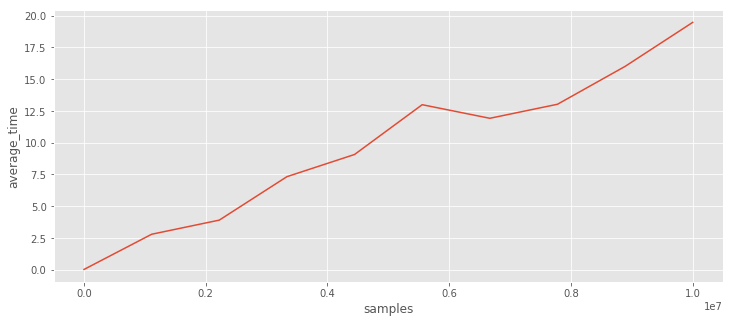

In [117]:
#Обычгный кмеанс
time_test_plot(KMeans(init='random', max_iter=1000, n_clusters=3, n_init=3))

далее время замерялось на 10000000 семплах

In [94]:
## Время выполнения алгоритма Kmeans из sklearn]
from sklearn.cluster import KMeans

%time KMeans(init='random', max_iter=1000, n_clusters=3, n_init=3).fit(X)

Wall time: 15 s


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
    n_clusters=3, n_init=3, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [95]:
## Время выполнения алгоритма MyKmeans
%time MyKmeans(k=3, max_iter=1000).fit(X)

Wall time: 9.95 s


In [96]:
## Время выполнения алгоритма MyKmeans++
%time MyKmeans(k=3, max_iter=1000, init='k-means').fit(X)

Wall time: 8.65 s


In [97]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
%time MiniBatchKMeans(k=3, max_iter=1000).fit(X)

Wall time: 2.84 s


In [98]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
%time MiniBatchKMeans(k=3, max_iter=1000, init='k-means').fit(X)

Wall time: 6.96 s


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [17]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [250]:
df_sns.size
df = df_sns.iloc[:,4:]
df_norm = (df.values-df.values.mean(axis=0))/df.values.std(axis=0)


In [251]:
keys = df.columns.values
keys

array(['basketball', 'football', 'soccer', 'softball', 'volleyball',
       'swimming', 'cheerleading', 'baseball', 'tennis', 'sports', 'cute',
       'sex', 'sexy', 'hot', 'kissed', 'dance', 'band', 'marching',
       'music', 'rock', 'god', 'church', 'jesus', 'bible', 'hair',
       'dress', 'blonde', 'mall', 'shopping', 'clothes', 'hollister',
       'abercrombie', 'die', 'death', 'drunk', 'drugs'], dtype=object)

In [252]:
## MyKMeans
cm_ = MyKmeans(k=9, random_state = 1234)
cm_.fit(df_norm)
cm_.iters

55

In [209]:
## MyKMeans++
cm = MyKmeans(k=9, init='k-means', random_state=1234)
cm.fit(df_norm)
cm.iters

60

In [207]:
## MyKMeans с MiniBatchMyKMeans
cm_ = MiniBatchKMeans(k=9, random_state=1234)
cm_.fit(df_norm)
cm_.iters

1000

In [208]:
## MyKMeans++ с MiniBatchMyKMeans
cm_ = MiniBatchKMeans(k=9, init='k-means', random_state=1234)
cm_.fit(df_norm)
cm_.iters

1000


##### Вывод

Я строил диаграммы как внизу для всех 4х класификаторов. Особо выделить какой либо класификатор трудно,
тк они все подвержены рандому и неустойчивы. Субъективно мне показалось лучшим взять класификатор MyKMeans++.


In [253]:

import matplotlib.pyplot as plt

F_ALL = ((df_sns['gender'] == 'F').sum())
M_ALL = ((df_sns['gender'] == 'M').sum())
F_C = (M_ALL + F_ALL)/(2.*float(F_ALL))
M_C = (M_ALL + F_ALL)/(2.*float(M_ALL))
#рассмотрим кластеры подробнее и выберем 5 наиболее востребованых тем
def show(i):
    c = cm.centroids
    args = np.argsort(c[i])[-6:]
    M_count = (df_sns[cm.labels==i]['gender'] == 'M').sum()
    F_count = (df_sns[cm.labels==i]['gender'] == 'F').sum()
    
    #учтём что в датасете женжин много больше мужчин
    M_relative = M_count*M_C
    F_relative = F_count*F_C
    summ = M_relative + F_relative
    M_relative /= summ
    F_relative /= summ

    print(u"количество ", (cm.labels==i).sum(), " M_absolute = ", M_count, " F_absolute = ", F_count)
    print ("F_relative = %.2f" % F_relative, " M_relative = %.2f" % M_relative)
    print (u"самые большие интересы: ",keys[args])
    plt.bar(range(c.shape[1]),c[i])
    plt.xticks(range(c.shape[1]), keys, rotation = 90)
    plt.show()


Кластер людей без особых интересов. женщин и мужчин поровну

количество  20911  M_absolute =  3737  F_absolute =  15021
F_relative = 0.49  M_relative = 0.51
самые большие интересы:  ['drunk' 'swimming' 'death' 'sexy' 'tennis' 'blonde']


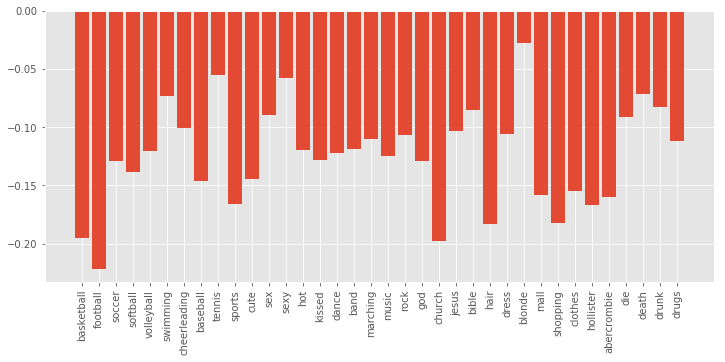

In [154]:
print(u"Кластер людей без особых интересов. женщин и мужчин поровну")
print("")
show(0)

Любители бухла и эротики, в основном женщины

количество  1013  M_absolute =  130  F_absolute =  828
F_relative = 0.60  M_relative = 0.40
самые большие интересы:  ['clothes' 'drunk' 'sex' 'hair' 'drugs' 'kissed']


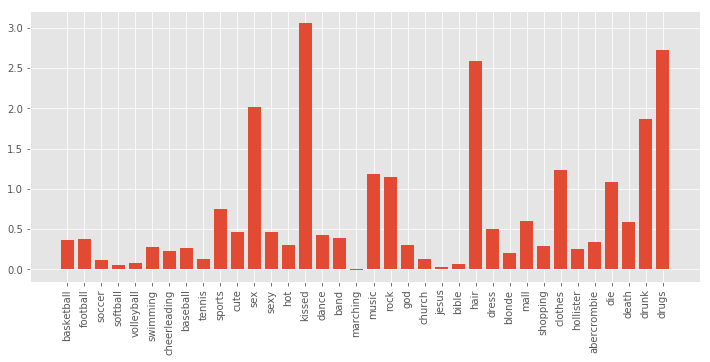

In [155]:
print(u"Любители бухла и эротики, в основном женщины")
print("")
show(1)

Любители спортивных игр

количество  2743  M_absolute =  890  F_absolute =  1705
F_relative = 0.31  M_relative = 0.69
самые большие интересы:  ['volleyball' 'sports' 'soccer' 'baseball' 'basketball' 'football']


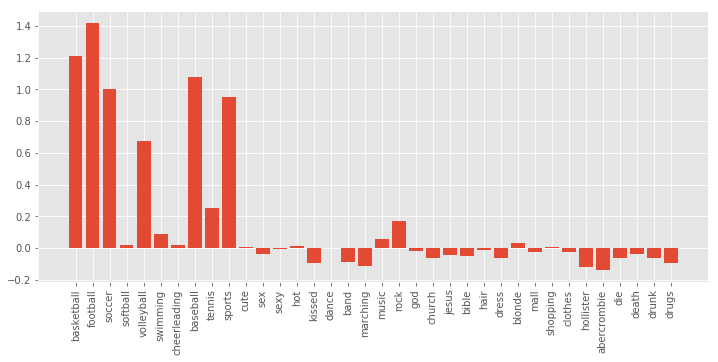

In [156]:
print(u"Любители спортивных игр")
print("")
show(2)

любители шоппинга, не удивительно что почти все женщины

количество  2577  M_absolute =  103  F_absolute =  2281
F_relative = 0.84  M_relative = 0.16
самые большие интересы:  ['hot' 'cute' 'mall' 'shopping' 'abercrombie' 'hollister']


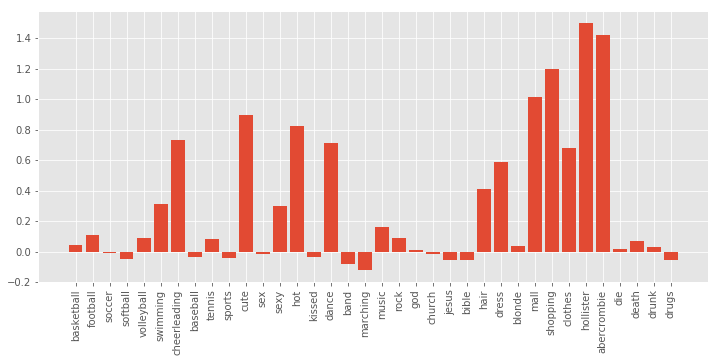

In [159]:
print(u"любители шоппинга, не удивительно что почти все женщины")
print("")
show(3)

Люди с суицидальными наклоностями. Не удивительно что их мало

количество  73  M_absolute =  22  F_absolute =  45
F_relative = 0.33  M_relative = 0.67
самые большие интересы:  ['god' 'sex' 'hair' 'blonde' 'death' 'die']


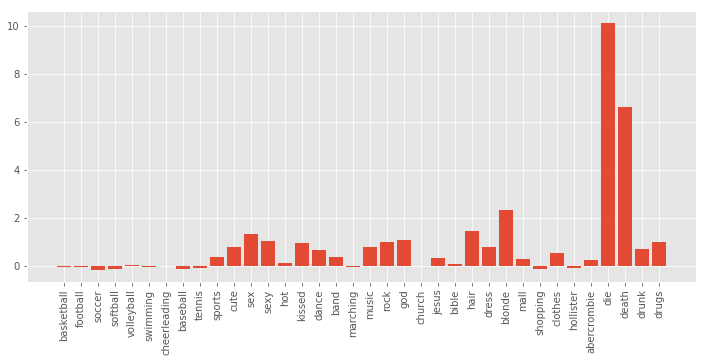

In [161]:
print(u"Люди с суицидальными наклоностями, возможно какая-то субкультура. Сосвем не интересен спорт. Не удивительно что их мало")
print("")
show(4)

Походу кроме библии и христианства их больше ничего не интересует. 
Похоже на сильно верующих христиан. Интересно что женщин больше

количество  1544  M_absolute =  190  F_absolute =  1243
F_relative = 0.61  M_relative = 0.39
самые большие интересы:  ['shopping' 'music' 'bible' 'jesus' 'god' 'church']


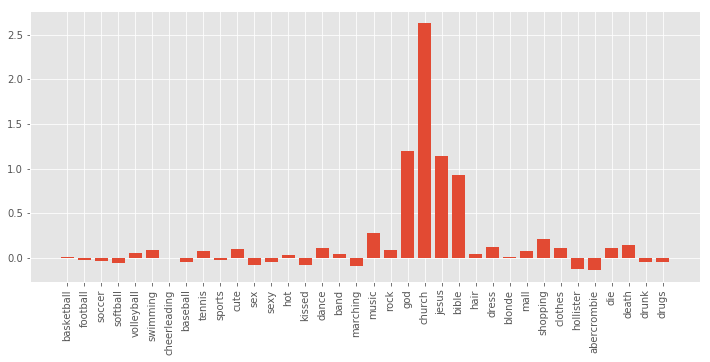

In [167]:
print(u"Походу кроме библии и христианства их больше ничего не интересует. \nПохоже на сильно верующих христиан. Интересно что женщин больше")
print("")
show(5)

Кластер заядлых игроков в софтбол?

количество  499  M_absolute =  0  F_absolute =  477
F_relative = 1.00  M_relative = 0.00
самые большие интересы:  ['football' 'shopping' 'sports' 'volleyball' 'basketball' 'softball']


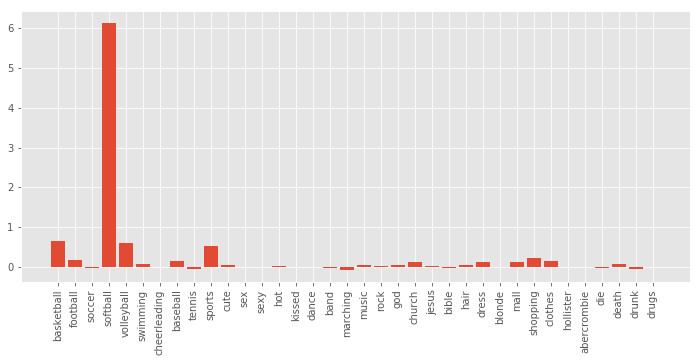

In [169]:
print(u"Кластер заядлых игроков в софтбол? Да ещё и одни женщины?")
print("")
show(6)

?

количество  594  M_absolute =  130  F_absolute =  429
F_relative = 0.44  M_relative = 0.56
самые большие интересы:  ['football' 'dress' 'rock' 'music' 'band' 'marching']


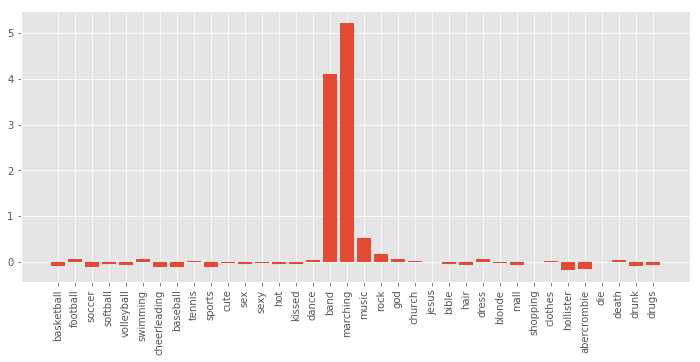

In [171]:
print(u"band, marching и больше ничего. Ребята играющие в оркестрах?:)")
print("")
show(7)

те же христиане, но тут скорее мужики, которые не ходят в церковь, их то можно было и в один кластер засунуть

количество  46  M_absolute =  20  F_absolute =  25
F_relative = 0.23  M_relative = 0.77
самые большие интересы:  ['die' 'death' 'church' 'god' 'bible' 'jesus']


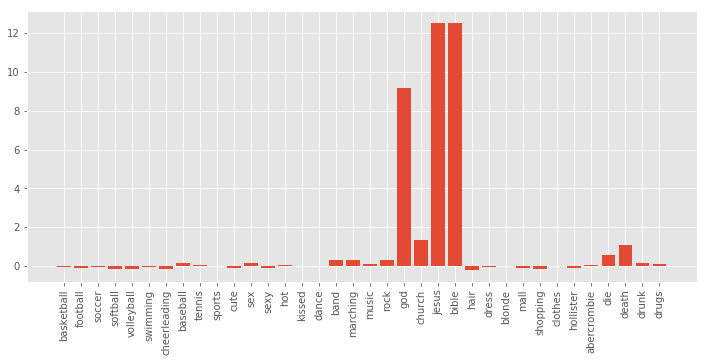

In [174]:
print(u"те же христиане, но тут скорее мужики, которые не ходят в церковь, их то можно было и в один кластер засунуть")
print("")
show(8)